### Using Tree data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import *
import seaborn as sns
from tqdm.notebook import tqdm

dendro = pd.read_feather("../data/17766_12.feather")
dendro

,dendroNr,DOY,species,growth,deltagrowth
0,HA_001_2012,0,Beech,0.000000,0.000000
1,HA_001_2012,1,Beech,0.154100,0.152446
2,HA_001_2012,2,Beech,1.460225,1.446028
3,HA_001_2012,3,Beech,4.169183,4.119561
4,HA_001_2012,4,Beech,3.907183,3.787263
...,...,...,...,...,...
30805,SH_076_2013,178,Beech,3909.054208,1.891602
30806,SH_076_2013,179,Beech,3908.649604,1.256104
30807,SH_076_2013,180,Beech,3908.473708,0.876465
30808,SH_076_2013,181,Beech,3908.421000,0.644775


# Fit models

In [2]:
import jaxopt
import jax
import jax.numpy as jnp

dendro_spcs = dendro[dendro.species.eq("Beech")]

def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)

In [3]:
dendro["deltagrowth"] = np.nan
weibull_params = dict()

for tree in tqdm(dendro.dendroNr.unique()):
    df_ = dendro[dendro.dendroNr.eq(tree)]
    y_ = jnp.array(df_.growth)
    x_ = jnp.array(df_.DOY)

    def f_(params):
        p0, p1, p2 = params
        return jnp.mean((y_ - (p0 * weibull_F(x_, p1, p2))) ** 2) #MSE Loss
        # return jnp.mean(#     jax.vmap(jax.tree_util.Partial(jaxopt.loss.huber_loss, delta = 10.))
        #     (y_, p0 * weibull_F(x_, p1, p2)) # Huber Loss
        # )

    solver = jaxopt.ScipyBoundedMinimize(fun = f_, tol = 1e-5)
    res = solver.run(jnp.array([max(y_), 1/(0.632*max(y_)), 3]), jnp.array([(0.1, 0.00001, 1), (100000, 1, 100)]))
    weibull = lambda x__ : res.params[0] * weibull_F(x__.ravel(), res.params[1], res.params[2])

    with np.printoptions(precision=3, suppress=True, threshold=5, floatmode="fixed"):
        print(tree, res.params, res.state.fun_val, res.state.status, res.state.iter_num, sep = '\t')

    dendro.loc[dendro['dendroNr'] == tree, 'deltagrowth'] = y_ - weibull(x_)
    weibull_params[tree] = res.params

  0%|          | 0/170 [00:00<?, ?it/s]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


HA_001_2012	[2312.554    0.010    3.072]	1072.8293	0	13
HA_001_2013	[2592.903    0.011    3.913]	3422.0156	0	15
HA_002_2012	[1740.840    0.009    2.983]	13177.077	0	4
HA_002_2013	[1213.812    0.009    2.984]	10173.627	0	5
HA_003_2012	[925.827   0.011   3.064]	6353.001	0	8
HA_003_2013	[1219.668    0.008    2.986]	17472.404	0	4
HA_004_2012	[1491.171    0.011    3.435]	6740.199	0	15
HA_004_2013	[1307.580    0.010    2.982]	17360.746	0	6
HA_005_2012	[704.221   0.010   2.991]	6278.5615	0	4
HA_005_2013	[1445.864    0.010    2.981]	13883.53	0	8
HA_006_2012	[1650.958    0.009    3.319]	843.89874	0	20
HA_006_2013	[2546.438    0.011    3.731]	4264.6523	0	14
HA_010_2012	[1088.115    0.010    2.984]	6738.086	0	6
HA_010_2013	[1366.216    0.010    2.989]	9705.482	0	6
HA_011_2012	[2860.746    0.010    2.947]	1846.243	0	7
HA_011_2013	[2315.804    0.011    4.039]	3444.6616	0	14
HA_012_2012	[2712.012    0.011    2.737]	3736.4602	0	13
HA_012_2013	[2706.025    0.012    3.589]	4171.027	0	14
HA_013_2012	[32

In [25]:
param_df = pd.concat([pd.DataFrame.from_dict(weibull_params, orient='index', dtype=float), dendro.groupby(['dendroNr']).agg({'species': 'first'})], axis=1)

param_df.reset_index().to_csv('../data/17766_Wparams.csv')

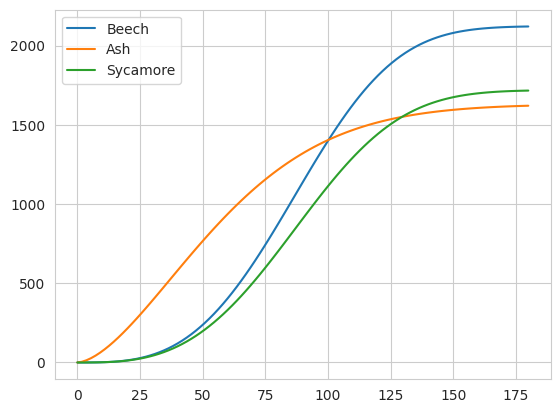

In [5]:
plt.figure()
for label_, (p1, p2, p3) in param_df.groupby('species').agg('mean').iterrows():
    plt.plot(np.linspace(0,180,100), p1 * weibull_F(np.linspace(0,180,100), p2, p3), label = label_)

#sns.lineplot(data=dendro[dendro.species.eq('Ash')], x = 'DOY', y = 'growth', units = 'dendroNr', alpha = .7, estimator=None)
plt.legend()
plt.show()

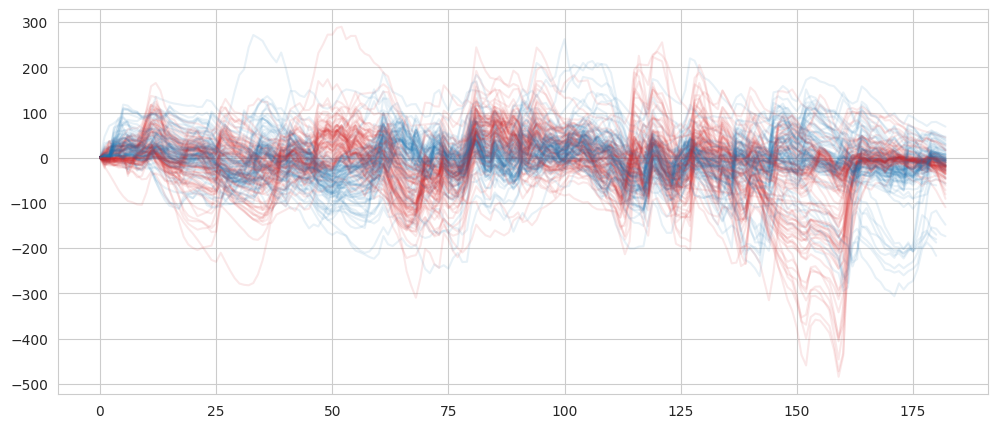

In [6]:
plt.figure(figsize=(12,5))

for i, tree in enumerate(dendro.dendroNr.unique()):
    #plt.scatter(dendro[dendro.dendroNr.eq(tree)].DOY, dendro[dendro.dendroNr.eq(tree)].deltagrowth, c = f"C{1 if '2012' in tree else 2}", alpha=.1)
    plt.plot(dendro[dendro.dendroNr.eq(tree)].DOY, dendro[dendro.dendroNr.eq(tree)].deltagrowth,
             c = f"C{0 if '2012' in tree else 3}", alpha=.1)

plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

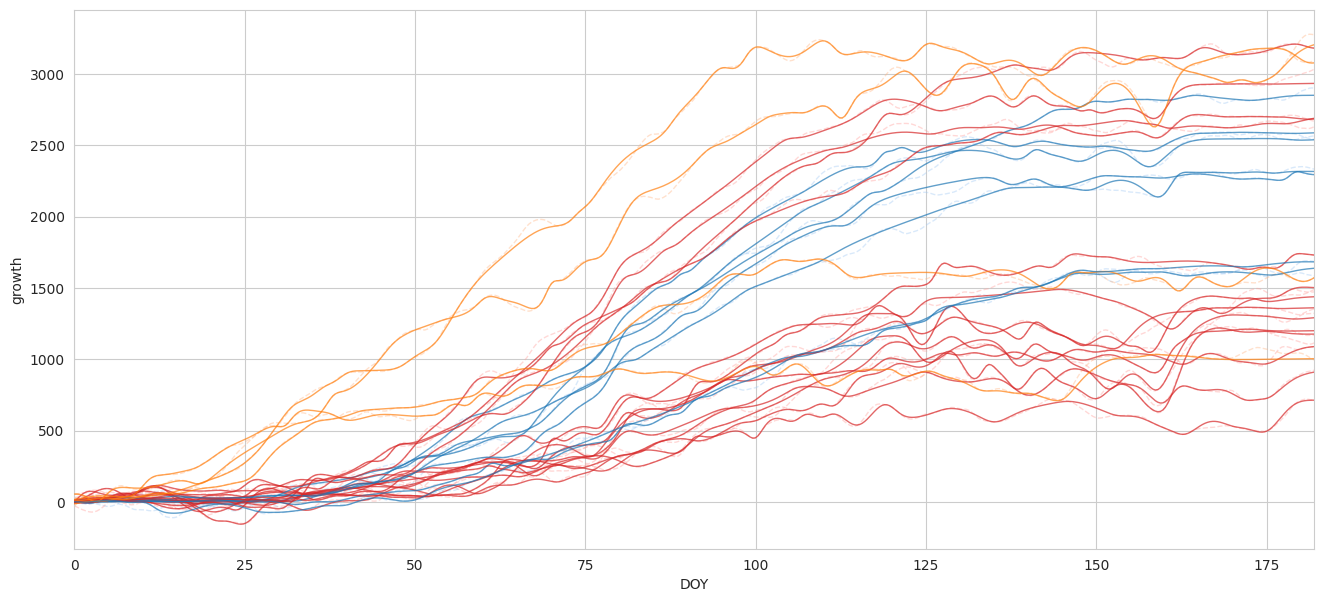

In [19]:
#tree = 'SH_076_2013'

plt.figure(figsize=(16, 7))

rng = np.random.default_rng()

X_test = np.linspace(0, dendro.DOY.max(), 500).reshape(-1, 1)

c = lambda s : 0 if s == "Beech" else (3 if s == "Sycamore" else 1)

for tree in tqdm(dendro.dendroNr.unique()[:25]):
    df_ = dendro.loc[dendro.dendroNr.eq(tree)]

    idx_train = np.sort(rng.integers(0, len(df_.DOY) - 1, 60))

    X_train = df_.DOY.iloc[idx_train].array.reshape(-1, 1)
    y_train = df_.deltagrowth.iloc[idx_train]

    kernel_ = 37**2 * Matern(length_scale=3, length_scale_bounds=(2,16), nu = 2.5) + WhiteKernel(noise_level=.01, noise_level_bounds="fixed")
    gp_model = gaussian_process.GaussianProcessRegressor(
        kernel=kernel_,
        #n_restarts_optimizer=2,
        #normalize_y=True,
        optimizer=None
    )

    gp_model.fit(X_train, y_train)
    mean_pred, std_pred = gp_model.predict(X_test, True)
    y_samples = gp_model.sample_y(X_test, 1)

    weibull_pred = weibull_params[tree][0] * weibull_F(X_test.ravel(), *weibull_params[tree][1:3])

    plt.plot(X_test, mean_pred + weibull_pred, lw=1, zorder=10, alpha = .7, c=sns.color_palette()[c(df_.species.iloc[0])])

    #plt.plot(df_.DOY, df_.growth, lw=1, zorder=10, alpha = .5, c=sns.color_palette("pastel")[c(df_.species.iloc[0])])

    # plt.fill_between(
    #     X_test.ravel(),
    #     mean_pred + weibull_pred - 1.96 * std_pred,
    #     mean_pred + weibull_pred + 1.96 * std_pred,
    #     alpha=.1, zorder=0, color=sns.color_palette("pastel")[c(df_.species.iloc[0])]
    # )

    for idx, single_prior in enumerate(y_samples.T):
        plt.plot(
            X_test, single_prior + weibull_pred
            , alpha=.4, lw=1, linestyle="dashed", c=sns.color_palette("pastel")[c(df_.species.iloc[0])]
        )

plt.xlabel("DOY")
plt.ylabel("growth")
plt.xlim(0, dendro.DOY.max())
plt.show()

# SPARSE

In [8]:
import jax
import jax.numpy as jnp

In [16]:
%%capture
# Import my GP
%run ../GP.ipynb

bw=49
NMLL: 157.20336890853224


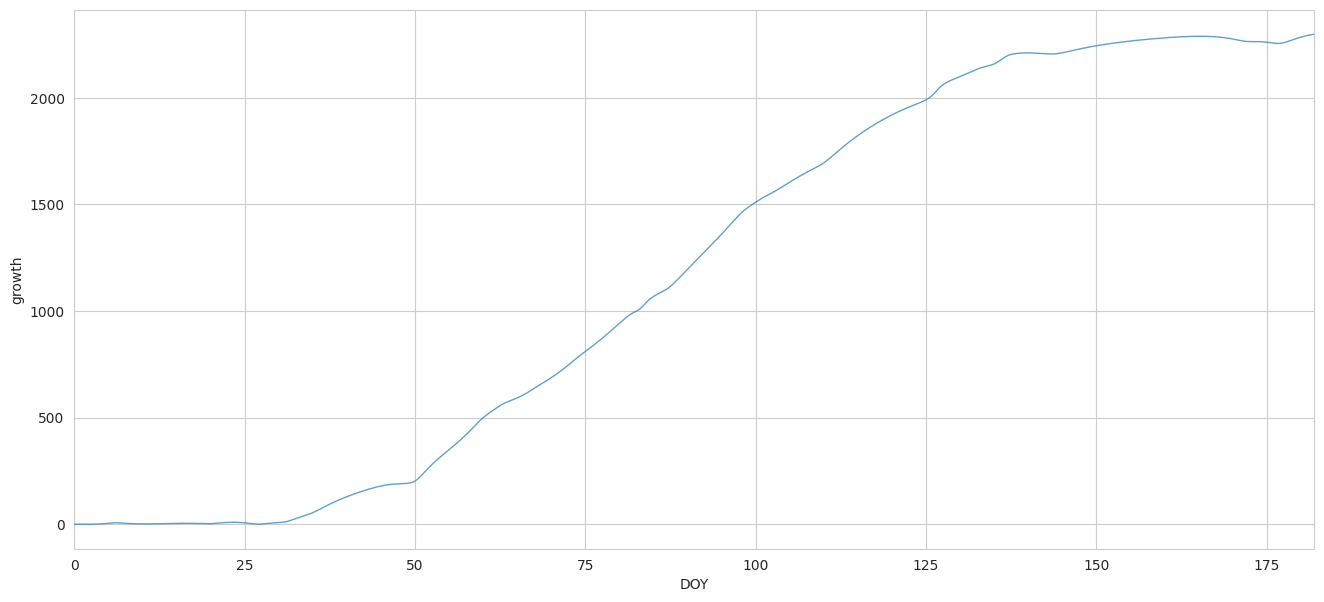

In [33]:
plt.figure(figsize=(16, 7))

X_test = jnp.linspace(0, dendro.DOY.max(), 500).reshape(-1, 1)

c = lambda s : 0 if s == "Beech" else (3 if s == "Sycamore" else 1)

for tree in dendro.dendroNr.unique()[:25]:
    df_ = dendro.loc[dendro.dendroNr.eq(tree)]

    #idx_train = jnp.sort(rng.integers(0, len(df_.DOY) - 1, 30))
    idx_train = jnp.sort(jax.random.randint(jax.random.PRNGKey(0), (50,), 0, len(df_.DOY) - 1))
    X_train = jnp.array(df_.DOY.iloc[idx_train].array).reshape(-1, 1)
    y_train = jnp.array(df_.deltagrowth.iloc[idx_train].array)

    # kernel_ = 37**2 * Matern(length_scale=3, length_scale_bounds=(2,16), nu = 2.5) + WhiteKernel(noise_level=.01, noise_level_bounds="fixed")
    # gp_model = gaussian_process.GaussianProcessRegressor(
    #     kernel=kernel_,
    #     #n_restarts_optimizer=2,
    #     #normalize_y=True,
    #     #optimizer=None
    # )
    def kernel_(s, l, x, y):
        #37**2 * Matern(length_scale=3, length_scale_bounds=(2,16), nu = 2.5) + WhiteKernel(noise_level=.01, noise_level_bounds="fixed")
        return MaternKernel32(s, l, x, y) * WendlandTapering(3, np.inf, x, y)
    gp_model = GPR(X_train, y_train, kernel_, jnp.array([37**2, 3]), eps = 0.01)
    #gp_model.fit(X_train, y_train)
    mean_pred = gp_model.predict(X_test, False)

    weibull_pred = weibull_params[tree][0] * weibull_F(X_test.ravel(), *weibull_params[tree][1:3])

    plt.plot(X_test, mean_pred + weibull_pred, lw=1, zorder=10, alpha = .7, c=sns.color_palette()[c(df_.species.iloc[0])])

    #plt.plot(df_.DOY, df_.growth, lw=1, zorder=10, alpha = .5, c=sns.color_palette("pastel")[c(df_.species.iloc[0])])

    # plt.fill_between(
    #     X_test.ravel(),
    #     mean_pred + weibull_pred - 1.96 * std_pred,
    #     mean_pred + weibull_pred + 1.96 * std_pred,
    #     alpha=.1, zorder=0, color=sns.color_palette("pastel")[c(df_.species.iloc[0])]
    # )
    break

plt.xlabel("DOY")
plt.ylabel("growth")
plt.xlim(0, dendro.DOY.max())
plt.show()